In [1]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
from scipy.sparse import coo_matrix, linalg
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans

In [2]:
G = nx.Graph()

G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(0,2)
G.add_edge(2,3)
G.add_edge(3,4)
G.add_edge(3,5)
G.add_edge(4,6)
G.add_edge(5,6)

flows = {}

flows[(0,1)] = 10.
flows[(1,2)] = 10
flows[(0,2)] = -10.
flows[(2,3)] = 0.
flows[(3,4)] = -10.
flows[(3,5)] = 10.
flows[(4,6)] = -10.
flows[(5,6)] = 10.

labelled_flows = {(1,2):10., (2,3):0., (3,5):10.}

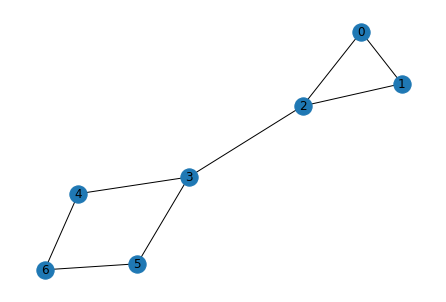

In [3]:
nx.draw(G, with_labels=True)

In [4]:
def flow_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        i = i + 1

    b = -B.dot(f0)

    row = []
    col = []
    data = []

    index = {}
    
    i = 0
    for ei in G.edges():
        j = 0
        for ej in G.edges():
            if ej not in labelled_flows:
                if ei == ej:
                    row.append(i)
                    col.append(j)
                    data.append(1.)

                    index[ej] = j

                j = j + 1
        i = i + 1

    sigma = coo_matrix((data, (row,col)), shape=(G.number_of_edges(), G.number_of_edges()-len(labelled_flows)))

    A = B.dot(sigma).tocoo()

    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]

    pred_flows = {}

    for e in index:
        pred_flows[e] = x[index[e]]
    
            
    return pred_flows

In [9]:
def flow_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]

    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
    
            
    return pred_flows

In [10]:
pred = flow_prediction(G, labelled_flows)

In [11]:
pred

{(0, 1): 9.99999999999,
 (0, 2): -9.99999999999,
 (1, 2): 10.0,
 (2, 3): 0.0,
 (3, 4): -9.999999999985,
 (3, 5): 10.0,
 (4, 6): -9.999999999980002,
 (5, 6): 9.999999999985}

In [12]:
flows

{(0, 1): 10.0,
 (1, 2): 10,
 (0, 2): -10.0,
 (2, 3): 0.0,
 (3, 4): -10.0,
 (3, 5): 10.0,
 (4, 6): -10.0,
 (5, 6): 10.0}

In [13]:
[(pred[k] - flows[k]) ** 2 for k in flows]

[9.998225376707202e-23,
 0.0,
 9.998225376707202e-23,
 0.0,
 2.249867147529859e-22,
 0.0,
 3.999290150682881e-22,
 2.249867147529859e-22]

In [8]:
pred

{(0, 1): 9.99999999999,
 (0, 2): -9.99999999999,
 (3, 4): -9.999999999985,
 (4, 6): -9.999999999980002,
 (5, 6): 9.999999999985}

In [98]:
def speed_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Speed prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    line_G = nx.line_graph(G)
    A = nx.adjacency_matrix(line_G)
    f0 = []
    
    A.data = A.data / np.repeat(np.add.reduceat(A.data, A.indptr[:-1]), np.diff(A.indptr))
   
    U = []
    L = []
    i = 0
    j = 0
    index = {}
    for e in line_G.nodes():
        if e in labelled_flows:
            f0.append(labelled_flows[e])
            L.append(i)
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    PUL = A[np.ix_(U, L)]
    f0 = np.array(f0)
    b = PUL.dot(f0)
    PUU = A[np.ix_(U, U)]
    A = scipy.sparse.identity(PUU.shape[0])-PUU   
    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]
    
    pred_flows = {}

    for e in index:
        pred_flows[e] = x[index[e]]
            
    return pred_flows

In [99]:
pred = speed_prediction(G, labelled_flows)

In [65]:
labelled_flows

{(1, 2): 10.0, (2, 3): 0.0, (3, 5): 10.0}

In [93]:
pred

{(0, 2): 5.999999999980802,
 (0, 1): 7.999999999978405,
 (5, 6): 8.571428571373056,
 (3, 4): 5.714285714244893,
 (4, 6): 7.142857142786134}

In [49]:
def al_flows_rrqr(G, ratio):
    B = nx.incidence_matrix(G, oriented=True).todense()
    VC = scipy.linalg.null_space(B)
    q, r, p = scipy.linalg.qr(VC.T, pivoting=True)
    edges = list(G.edges())
    selected = []

    for e in list(p[0:int(ratio*G.number_of_edges())]):
        selected.append(edges[e])
        
    return selected

EdgeView([((0, 2), (1, 2)), ((0, 2), (2, 3)), ((0, 2), (0, 1)), ((1, 2), (2, 3)), ((1, 2), (0, 1)), ((2, 3), (3, 4)), ((2, 3), (3, 5)), ((3, 5), (5, 6)), ((3, 5), (3, 4)), ((5, 6), (4, 6)), ((3, 4), (4, 6))])

In [171]:
def al_flows_rb(G, ratio, n_dim=2):
    A = nx.adjacency_matrix(G)
    nodes = list(G.nodes())
    embedding = SpectralEmbedding(n_components=n_dim, affinity='precomputed')
    spec_emb = embedding.fit_transform(A)
    selected = []
    
    clusters = [list(np.arange(0,G.number_of_nodes()))]
    
    while len(selected) < int(ratio*G.number_of_edges()):
        max_cluster = 0
        
        for i in range(len(clusters)):
            if len(clusters[i]) > len(clusters[max_cluster]):
                max_cluster = i
        
        cluster = clusters[max_cluster]
        
        if len(cluster) <= 2:
            break
            
        X = spec_emb[cluster,:]
                
        labels = KMeans(n_clusters=2, random_state=0).fit(X).labels_
        clusters[max_cluster] = []
        clusters.append([])
        
        for i in range(len(cluster)):
            if labels[i] == 0:
                clusters[-1].append(cluster[i])
            else:
                clusters[-2].append(cluster[i])
        
        for v in clusters[-1]:
            for u in clusters[-2]:
                if G.has_edge(nodes[v], nodes[u]):
                    selected.append((nodes[v], nodes[u]))
                
                    if len(selected) >= int(ratio*G.number_of_edges()):
                        break
                        
    return selected

In [172]:
al_flows_rb(G, 1, n_dim=2)

[(3, 2), (3, 4), (3, 5), (0, 2), (1, 2), (4, 6), (5, 6), (4, 6), (5, 6)]

In [158]:
l = [[1,2], [3,4]]
x = l[-1]

In [159]:
l[-1] = []

In [160]:
x

[3, 4]

In [29]:
x[2]

2

In [39]:
f0

array([10.,  0., 10.,  0.,  0.,  0.,  0.,  0.])

In [52]:
B.todense()

matrix([[-1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]])

In [55]:
(B.T).dot(B).todense()

matrix([[ 2.,  1., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  2.,  1., -1.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  2., -1.,  0.,  0.,  0.,  0.],
        [ 0., -1., -1.,  2., -1., -1.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  1., -1.,  0.],
        [ 0.,  0.,  0., -1.,  1.,  2.,  0., -1.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  2.,  1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  2.]])

In [56]:
G.edges()

EdgeView([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4, 6), (5, 6)])

In [57]:
f0

array([ 0.,  0., 10.,  0.,  0., 10.,  0.,  0.])